开始
结束


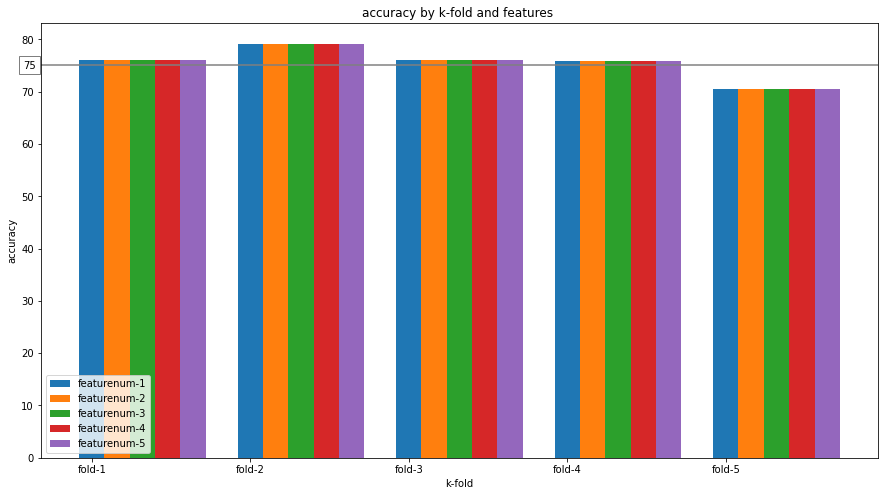

In [3]:
import numpy as np
from sklearn import linear_model, datasets
import pandas as pd
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.autograd import Variable
import numpy as np
from Logistic import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import KFold
import heapq
from numpy import *
from random import choice

savepath = "D:/WorkSpace/Shell/DataMining/result/"

def loadCSVfile2(filepath,labelstr,featurestr):
    odata = pd.read_csv(filepath)
    label = odata[labelstr] ##不包括表头
    feature = odata.drop([featurestr], axis=1) #除去label列之外的所有feature值

    return np.array(label).reshape(-1), np.array(feature) #返回array类型的数据

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


def pearsonFeature(feature, label):
    pearson = np.corrcoef(feature.reshape(-1), label)[0][1]
    return pearson

##处理Nan值
def handleNan(feature):

    contain_nan = (True in np.isnan(feature))
    if contain_nan is True:

        index_nan = 0
        for x in feature:##将nan替换为0或1
            if np.isnan(x):
                feature[index_nan] = choice([0, 1])
            index_nan += 1
    return feature


##对特征“wbc”到“size”的异常值0进行处理，使用对应特征列的平均值进行填充
def handlErrorValue(feature_all, feature_select_num):
    feature_list = []
    pearson_list = []
    feature_pearson = []
    for index in range(16):
        feature = feature_all[:,index:1 + index]  #提取特征值列
        ##处理Nan特征值
        feature = handleNan(feature)
        pearson_list.append(pearsonFeature(feature, label))
        #np.place(feature, feature == float(0), feature.mean())  #将特征值为0的替换为平均值  不需要做
        feature_list.append(feature)
    ##挑选pearson系数最高的特征下标
    pearson_index = map(pearson_list.index, heapq.nlargest(feature_select_num, pearson_list))
    pearson_index = list(pearson_index)
    ##将pearson挑选出的最好的特征
    for index in pearson_index:
        feature_pearson.append(feature_list[index])

    feature_all  = standardization(np.array(feature_pearson).T.reshape(478, feature_select_num)) ##标准化
    #feature_all = preprocessing.scale(np.array(feature_pearson).T.reshape(-1, feature_select_num)) ##z-score归一化

    return feature_all

##保存结果报告文件
def save_to_file(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()

##对五折结果进行柱状图的刻画
def histogramPicture(acc_all_list):
     # G1,G2,G3,G4,G5小组的分数。
    labels = ['fold-1', 'fold-2', 'fold-3', 'fold-4', 'fold-5']
    x = np.arange(len(labels))
    width = 0.16  # 柱形图的宽度
    plt.figure(figsize=(15, 8))
    plt.xticks(x, labels)  # 设置具体刻度。
    plt.xlabel('k-fold')  # x轴标签
    plt.ylabel('accuracy')  # y轴标签
    plt.title('accuracy by k-fold and features ')  # 该柱形图的标题
    num = 0
    for acc_list in acc_all_list:
        plt.bar(x + num * width, list(map(float, acc_list[0:5])), width,  label='featurenum-' + str(num + 1))  # 计算出左边柱形图的位置。
        num = num + 1

    plt.axhline(75, color="gray") #画出75%的线
    plt.text(-0.35, 75, "75", va='center', ha="right", bbox=dict(facecolor="w",alpha=0.5))##添加文字
    plt.legend()

    plt.savefig(savepath + "/picture/logistic_acc.svg")
    plt.show()


def autolabel(ax,rects):
    """在每个柱形条上方添加一个文本标签，显示高度。"""
    index = 0
    for rect in rects:
        height = rect.get_height()  # 获取柱形条的高度。
        # annotate() 用于在图形上给数据添加文本注解(注释)。
        ax.annotate('{}'.format(height, ".2f"),  # s 注释文本内容
                    xy=(rect.get_x() + rect.get_width() * index, height),  # 被注释的坐标点：xy=(横坐标，纵坐标)，即每个柱形条的顶部中心。
                    xytext=(0, 3),  # 注释文本的坐标点（相对于被注释点取坐标）：xytext(横坐标，纵坐标)。
                    textcoords="offset points",  # 被注释点的坐标系属性：点，像素，百分比等。"offset points"指偏移量，单位：点。
                    ha='center')  # ha='center' 让注解居中
        index = index + 1
#PCA
def PCA_Featrue(feature_list):
    # ##进行PCA分析
    pca = PCA(n_components = 2) #n_components代表保存的特征数
    pca.fit(feature_list)
    low_feature = pca.transform(feature_list)   #降低维度
    print(pca.explained_variance_ratio_)  ##贡献值

    return low_feature
##保存模型
def saveModule(modules, savepath, num):
    torch.save(modules, savepath + str(num) + '.pkl')  # entire net

##训练模型
def trainModule(data, label, knum, feature_num):

    logistic_model=LogisticRegression()
    if torch.cuda.is_available():
        logistic_model.cuda()
    #定义损失函数和优化器
    criterion=nn.BCELoss()   #选用BCE损失函数,该损失函数是只用于2分类问题的损失函数
    optimizer=torch.optim.SGD(logistic_model.parameters(),lr=1e-2,momentum=0.3)  #采用随机梯度下降的方法
    #开始训练
    #训练10000次
    for epoch in range(10000):
        if torch.cuda.is_available():
            x_data=torch.from_numpy(data).cuda()  ##将数据转为torch 并放入GPU
            y_data=torch.from_numpy(label).cuda()
        else:
            x_data=torch.from_numpy(data)
            y_data=torch.from_numpy(label)
        out=logistic_model(x_data.float())  #根据逻辑回归模型拟合出的y值
        out=out.float()
        y_data = y_data.float()
        loss=criterion(out.reshape(-1, 1),y_data.reshape(-1, 1))  #计算损失函数
        ##反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        saveModule(logistic_model,"./logistics_net/feature_"+ str(feature_num) +"_logistics_", knum)
        # #每隔20轮打印一下当前的误差和精度
        # if (epoch+1) % 100 == 0:
        #     print('-'* 10)
        #     print('epoch {}'.format(epoch+1))  #误差
        #     print('loss is {:.4f}'.format(print_loss))
        #     print('acc is {:.4f}'.format(acc))  #精度
    return logistic_model.cpu()

def save_to_file(file_name, contents):
    fh = open(file_name, 'w')
    fh.write(contents)
    fh.close()

def mean(list):
    sum = 0
    for num in list:
        sum = float(num) + sum
    return format(sum/5, ".2f")

def kFoldGetResult(feature_all, label, feature_num, k_unm):
    accuracy_all_list = []
    for num in range(1,feature_num + 1):## 选择1-5个特征的数据情况下进行训练和测试
        feature_list = handlErrorValue(feature_all, feature_num)
        kfold = KFold(n_splits = k_unm) #设立五折
        index = 0
        accuracy_list = []
        for train_index, test_index in kfold.split(feature_list):
            ##提取训练数据和测试数据
            train_data, test_data = feature_list[train_index], feature_list[test_index]
            train_label, test_label = label[train_index], label[test_index]
            #训练模型
            logistic_model = trainModule(train_data, train_label, index + 1, num)
            test_data_torch=torch.from_numpy(test_data)
            out = logistic_model(test_data_torch.float())
            pred=out.ge(0.5).float()  #以0.5为阈值进行分类
            acc = accuracy_score(test_label,pred.numpy().squeeze())  #计算精度
            accuracy_list.append(format(acc * 100,".2f")) ##将五折准确率记录起来
            index = index + 1
        accuracy_list.append(mean(accuracy_list))
        accuracy_all_list.append(accuracy_list)
    return accuracy_all_list
if __name__ == "__main__":
    ##加载数据
    label, feature_all = loadCSVfile2("train.csv", 'group', 'group')
    np.place(label, label == float(2), 0)  ##为了logistic，将标签为2换成0
    print("开始")
    acc_list = kFoldGetResult(feature_all, label, feature_num=5, k_unm=5)
    ##保存结果
    save_to_file(savepath + "acc/logistics_acc.txt",str(acc_list))
    ##画出K折交叉的图
    histogramPicture(acc_list)
    print("结束")